Author: Darshan Sundaram

In [1]:
from __future__ import print_function, division

import torch
torch.manual_seed(9)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
x3 = torch.get_rng_state()
torch.set_rng_state(x3)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
np.random.seed(9)
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, classification_report
from sklearn.metrics.cluster import contingency_matrix
import inspect
plt.ion()   # interactive mode
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import math
import pandas as pd

The code for the following assignment has been adapted from the official docs of pytorch found here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Data Augmentation

In [2]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'img'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")

In [3]:
dataset_sizes['train']

125

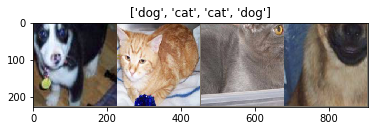

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Building

In [6]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)



criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Entropy Loss Optimization and Prediction

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    val_bank = []
    tr_bank = []
    runiter = {}
    trueiter = {}
    
    for epoch in range(num_epochs):
        total_loss = 0
        scheduler.step()
        model.train()  # Set model to training mode
        for inputs, labels in dataloaders['train']:
            X = inputs.to(device)
            y = labels.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            # getting training quality data
            current_loss = loss.item()
            total_loss += current_loss
                    
                
        val_losses = 0
        precision, recall, f1, accuracy,bankp,bankt = [], [], [], [], [], []
        model.eval()   # Set model to evaluate 
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                X = inputs.to(device)
                y = labels.to(device)
                        

                outputs = model(X) # this get's the prediction from the network
                loss= criterion(outputs,y)
                current_loss = loss.item()
                val_losses += current_loss
                predicted_classes = torch.max(outputs, 1)[1]
                bankp.append(predicted_classes.data.tolist())
                bankt.append(y.data.tolist())
        tr_bank.append(total_loss/dataset_sizes["train"])
        val_bank.append(val_losses/dataset_sizes["val"])
        bankt = sum(bankt,[])
        bankp = sum(bankp,[])
        runiter[epoch] = bankp
        trueiter[epoch] = bankt
        print("Validation accuracy:")
        print(accuracy_score(bankt,bankp))
        if epoch in (0,9,19,29,39,49):
            print("Epoch #", epoch+1)
            print('-' * 10)
            print("training loss: ",(total_loss/dataset_sizes["train"]), "validation loss: ",(val_losses/dataset_sizes["val"]))
    plt.figure()
    plt.plot(range(1,51,1),tr_bank, label = "Training Loss")
    plt.plot(range(1,51,1),val_bank, label = "Validation Loss")
    plt.legend(loc = 'best')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.title("Loss vs epoch")
    return tr_bank, val_bank, runiter, trueiter

Validation accuracy:
0.56
Epoch # 1
----------
training loss:  0.6548729305267333 validation loss:  0.7027931523323059
Validation accuracy:
0.57
Validation accuracy:
0.59
Validation accuracy:
0.55
Validation accuracy:
0.6
Validation accuracy:
0.59
Validation accuracy:
0.59
Validation accuracy:
0.59
Validation accuracy:
0.6
Validation accuracy:
0.63
Epoch # 10
----------
training loss:  0.6620518882274627 validation loss:  0.7310429358482361
Validation accuracy:
0.61
Validation accuracy:
0.63
Validation accuracy:
0.59
Validation accuracy:
0.63
Validation accuracy:
0.65
Validation accuracy:
0.55
Validation accuracy:
0.61
Validation accuracy:
0.57
Validation accuracy:
0.6
Validation accuracy:
0.61
Epoch # 20
----------
training loss:  0.6466409091949463 validation loss:  0.6810499954223633
Validation accuracy:
0.63
Validation accuracy:
0.59
Validation accuracy:
0.57
Validation accuracy:
0.59
Validation accuracy:
0.58
Validation accuracy:
0.63
Validation accuracy:
0.61
Validation accuracy:

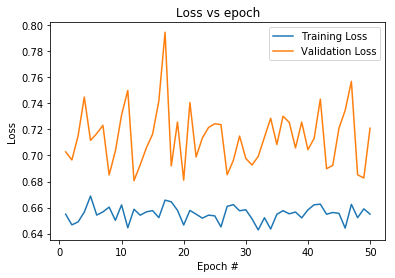

In [16]:
tr_bank, val_bank, runiter, trueiter = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

In [17]:
x1 = val_bank.index(min(val_bank)) #epoch with lowest val loss / the 15th epoch or 14 indexing at 0

In [18]:
x1

11

In [19]:
act = pd.Series(trueiter[x1],name = "Actual")
pr = pd.Series(runiter[x1], name = "Predicted")
pd.crosstab(act,pr)

Predicted,0,1
Actual,,
0,33,17
1,20,30


In [20]:
print("The accuracy score is, ",accuracy_score(trueiter[x1],runiter[x1])*100, "%")
print("The precision score is, ",precision_score(trueiter[x1],runiter[x1])*100, "%")
print("The recall score is, ",recall_score(trueiter[x1],runiter[x1])*100, "%")
print("The F1 score is, ",round(f1_score(trueiter[x1],runiter[x1])*100,5), "%")

The accuracy score is,  63.0 %
The precision score is,  63.829787234042556 %
The recall score is,  60.0 %
The F1 score is,  61.85567 %


## Pre-Trained Resnet

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    val_bank = []
    tr_bank = []
    runiter = {}
    trueiter = {}
    for epoch in range(num_epochs):
        total_loss = 0
        scheduler.step()
        model.train()  # Set model to training mode
        for inputs, labels in dataloaders['train']:
            X = inputs.to(device)
            y = labels.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            # getting training quality data
            current_loss = loss.item()
            total_loss += current_loss
                    
                
        val_losses = 0
        precision, recall, f1, accuracy,bankp,bankt = [], [], [], [], [], []
        model.eval()   # Set model to evaluate 
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                X = inputs.to(device)
                y = labels.to(device)
                        

                outputs = model(X) # this get's the prediction from the network
                loss= criterion(outputs,y)
                current_loss = loss.item()
                val_losses += current_loss
                predicted_classes = torch.max(outputs, 1)[1]
                bankp.append(predicted_classes.data.tolist())
                bankt.append(y.data.tolist())
        tr_bank.append(total_loss/dataset_sizes["train"])
        val_bank.append(val_losses/dataset_sizes["val"])
        bankt = sum(bankt,[])
        bankp = sum(bankp,[])
        runiter[epoch] = bankp
        trueiter[epoch] = bankt
        print("Validation accuracy:")
        print(accuracy_score(bankt,bankp))
        if epoch % 5 == 0:
            print("Epoch #", epoch+1)
            print('-' * 10)
            print("training loss: ",(total_loss/dataset_sizes["train"]), "validation loss: ",(val_losses/dataset_sizes["val"]))
    plt.figure()
    plt.plot(range(1,21,1),tr_bank, label = "Training Loss")
    plt.plot(range(1,21,1),val_bank, label = "Validation Loss")
    plt.legend(loc = 'best')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.title("Loss vs epoch")
    return tr_bank, val_bank, runiter, trueiter

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Validation accuracy:
0.94
Epoch # 1
----------
training loss:  0.5018071608543396 validation loss:  0.1550131693482399
Validation accuracy:
0.96
Validation accuracy:
0.93
Validation accuracy:
0.97
Validation accuracy:
0.97
Validation accuracy:
0.96
Epoch # 6
----------
training loss:  0.225239778727293 validation loss:  0.11665887475013732
Validation accuracy:
0.96
Validation accuracy:
0.98
Validation accuracy:
0.95
Validation accuracy:
0.96
Validation accuracy:
0.96
Epoch # 11
----------
training loss:  0.33263659733533857 validation loss:  0.07843030542135239
Validation accuracy:
0.96
Validation accuracy:
0.96
Validation accuracy:
0.97
Validation accuracy:
0.97
Validation accuracy:
0.97
Epoch # 16
----------
training loss:  0.23511590963602066 validation loss:  0.09432811960577965
Validation accuracy:
0.97
Validation accuracy:
0.97
Validation accuracy:
0.97
Validation accuracy:
0.97


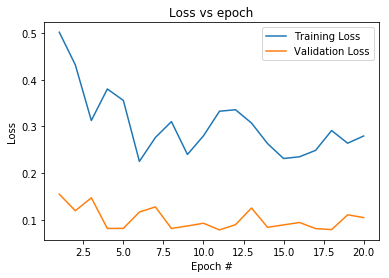

In [26]:
tr_bank, val_bank, runiter, trueiter = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

In [27]:
x2 = val_bank.index(min(val_bank)) #epoch with lowest val loss / the 15th epoch or 14 indexing at 0

In [28]:
x2

10

In [29]:
act = pd.Series(trueiter[x2],name = "Actual")
pr = pd.Series(runiter[x2], name = "Predicted")
pd.crosstab(act,pr)

Predicted,0,1
Actual,,
0,47,3
1,1,49


In [30]:
accuracy_score(trueiter[x2],runiter[x2])

0.96

In [31]:
print("The accuracy score is, ",accuracy_score(trueiter[x2],runiter[x2])*100, "%")
print("The precision score is, ",precision_score(trueiter[x2],runiter[x2])*100, "%")
print("The recall score is, ",recall_score(trueiter[x2],runiter[x2])*100, "%")
print("The F1 score is, ",round(f1_score(trueiter[x2],runiter[x2])*100,5), "%")

The accuracy score is,  96.0 %
The precision score is,  94.23076923076923 %
The recall score is,  98.0 %
The F1 score is,  96.07843 %


The difference is stark and evident. We achieve a very high metric across the board with the pretrained model compared to the model trained from scratch. The pretrained model has an accuracy of 96% and an F1 od 96% compared to 63% and 61% in the model trained from scratch. Additionally, we can see the tangible effect of the pretrained model by looking at the validation and training loss curves. In the model trained from scratch, we see the validation loss greater than training; which is to be expected when training and predicting on unseen data. However, the pretrained model we see the opposite. The validation loss is less than training loss. This represents neither overfitting or underfitting, and carries over the training the RESNET18 model has acquired previously. As a result, with the training we gave it, we notice a greater level of generalizability that exceeds the performance that would be normally expected. 

This excercise demonstrates the power of a residual network model that carries over the work done over many years on an extremely large dataset in comparison to a vanilla model that is trained on a few hundred images. 